In [1]:
# !pip3 install kafka-python==1.4.7 streamz==0.5.2 --user

In [2]:
import os
import sys

SOURCE_DIR = os.path.dirname(os.path.dirname(os.path.abspath(__name__)))
sys.path.insert(0, SOURCE_DIR)

In [3]:
# os.environ['ENABLE_JSON_LOGGING'] = 'true'
os.environ['LOGLEVEL'] = 'DEBUG'
os.environ['ENABLE_OPENTELEMETRY_JAEGER'] = 'true'

In [4]:
import waterhealer as wh
from waterhealer import Stream
import json
import time
import logging

In [5]:
from dask.distributed import Client, LocalCluster
cluster = LocalCluster(processes = False)
client = Client(cluster)

In [6]:
def json_loads(rows):
    results = []
    for row in rows:
        results.append(json.loads(row))
    time.sleep(2)
    return results

def increment_left(rows):
    results = []
    for row in rows:
        row = row.copy()
        row['left'] = row['data'] + 1
        results.append(row)
    return results

def increment_right(rows):
    results = []
    for row in rows:
        row = row.copy()
        row['right'] = row['data'] + 1
        results.append(row)
    time.sleep(2)
    return results

def combine(tuples):

    left, right = tuples
    results = []
    for i in range(len(left)):
        logging.info(f"need to combine {left[i]['left'] + right[i]['right']}")
        results.append(left[i]['left'] + right[i]['right'])
        
    return results

In [7]:
# source = Stream()
# partition = source.scatter().partition_time(0.5, checkpoint = True)
# s = partition.map(json_loads, checkpoint = True)
# left = s.map(increment_left, checkpoint = True)
# right = s.map(increment_right, checkpoint = True)
# gather = left.zip(right).map(combine, checkpoint = True).buffer(8).gather()

In [8]:
source = Stream()
partition = source.scatter().partition_time(0.5, checkpoint = True)
partition.map(json_loads, checkpoint = True).buffer(8).gather().sink(print)

Output()

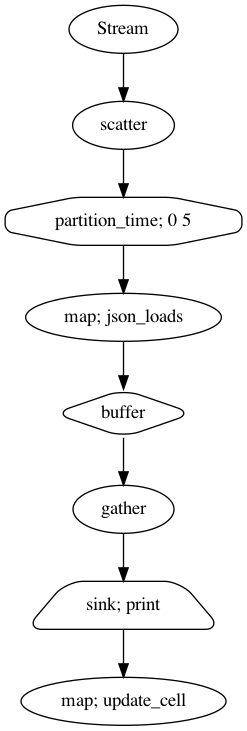

In [9]:
source.visualize()

In [10]:
i = 0
data = {'i': i, 'data': i + 1}
source.emit(json.dumps(data))

1202cc2f-7c2c-424b-a980-3f663faf8da0 Stream
1202cc2f-7c2c-424b-a980-3f663faf8da0 scatter
c3ad492a-0268-4b7a-bf83-a7fee69aaa03 partition_time
c3ad492a-0268-4b7a-bf83-a7fee69aaa03 map.json_loads
c3ad492a-0268-4b7a-bf83-a7fee69aaa03 buffer
c3ad492a-0268-4b7a-bf83-a7fee69aaa03 gather
[{'i': 0, 'data': 1}]


In [ ]:
for i in range(20):
    data = {'i': i, 'data': i + 1}
    source.emit(json.dumps(data))
    time.sleep(0.3)

In [ ]:
source.wait()

In [ ]:
source.checkpoint